In [1]:
import sys
sys.path.append('../')
import torch 
import torch.nn as nn
from torchvision import datasets,models,transforms
import pandas as pd 
import os
import glob
import numpy as np
from src import config 
import time
import copy

In [2]:
train_df = pd.read_csv(os.path.join('..',config.TRAINING_DATA,'train.csv'))
train_df.head()

,filename,label
0,0-with-mask.jpg,with_mask
1,1-with-mask.jpg,with_mask
2,10-with-mask.jpg,with_mask
3,100-with-mask.jpg,with_mask
4,101-with-mask.jpg,with_mask


In [3]:
test_df = pd.read_csv(os.path.join('..',config.TESTING_DATA,'test.csv'))
test_df.head()

,filename,label
0,augmented_image_227.jpg,with_mask
1,augmented_image_228.jpg,with_mask
2,augmented_image_23.jpg,with_mask
3,augmented_image_230.jpg,with_mask
4,augmented_image_232.jpg,with_mask


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
data_dir = '../data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}

In [6]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1096
    Root location: ../data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 276
    Root location: ../data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=4, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [9]:
class_names = image_datasets['train'].classes

In [10]:
class_names

['with_mask', 'without_mask']

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cpu')

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [14]:
dataset_sizes

{'train': 1096, 'test': 276}

In [18]:
# model_ft = models.resnet101(pretrained=True)
model_ft = models.mobilenet_v2(pretrained=True)

# num_frts = model_ft.fc.in_features
num_frts = model_ft.classifier[1].in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = torch.optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    training_losses = []
    validation_losses = []
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            training_losses.append(epoch_loss) if phase=='train' else validation_losses.append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    
    return model,training_losses,validation_losses

In [17]:
model_ft,training_losses,validation_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


C:\Users\somya\.conda\envs\facemaskdetection\lib\site-packages\torch\optim\lr_scheduler.py:118: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.3614 Acc:0.8433

test Loss: 0.0536 Acc:0.9928

Epoch 2/20
----------
train Loss: 0.1944 Acc:0.9203

test Loss: 0.0330 Acc:0.9964

Epoch 3/20
----------
train Loss: 0.1077 Acc:0.9561

test Loss: 0.0331 Acc:0.9964

Epoch 4/20
----------
train Loss: 0.0968 Acc:0.9543

test Loss: 0.0179 Acc:0.9928

Epoch 5/20
----------
train Loss: 0.0932 Acc:0.9552

test Loss: 0.0121 Acc:1.0000

Epoch 6/20
----------
train Loss: 0.0836 Acc:0.9606

test Loss: 0.0232 Acc:1.0000

Epoch 7/20
----------
train Loss: 0.0709 Acc:0.9624

test Loss: 0.0188 Acc:1.0000

Epoch 8/20
----------
train Loss: 0.0699 Acc:0.9705

test Loss: 0.0112 Acc:1.0000

Epoch 9/20
----------
train Loss: 0.0552 Acc:0.9722

test Loss: 0.0114 Acc:1.0000

Epoch 10/20
----------
train Loss: 0.0901 Acc:0.9508

test Loss: 0.0092 Acc:1.0000

Epoch 11/20
----------
train Loss: 0.0660 Acc:0.9669

test Loss: 0.0105 Acc:1.0000

Epoch 12/20
----------
train Loss: 0.0541 Acc:0.9758

test Loss: 0.0063 Acc:1.0000

Epoch 13/20
----------


In [21]:
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

In [22]:
torch.save(model_ft,os.path.join('..','saved_models',f'facemaskdetection_new_mask_types{datetime.now()}.pth'))

Text(0.5, 0.98, 'Training History')

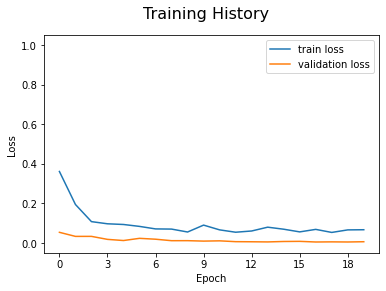

In [33]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots()

ax.plot(training_losses, label='train loss')
ax.plot(validation_losses, label='validation loss')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_ylim([-0.05, 1.05])
ax.legend()
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
fig.suptitle('Training History', fontsize=16)
